# Example 3: Learning battery manufacturing data
## SI Section 2.5: 4-input 1-output battery manufacturing data
### References:
- INN paper: https://www.nature.com/articles/s41467-025-63790-8
- Data source: https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/batt.201900135

Cunha, R.P., Lombardo, T., Primo, E.N. and Franco, A.A., 2020. Artificial intelligence investigation of NMC cathode manufacturing parameters interdependencies. Batteries & Supercaps, 3(1), pp.60-67.

In this example, we fit a 4-input 1-output battery manufacturing data.

**Inputs:**
- x1: active material mass content (%)
- x2: solid-to-liquid ratio (%)
- x3: comma gap (um)
- x4: viscosity (Pa·s)

**Output:**
- u: active material mass loading (mg·cm⁻²)

656 experimental data points are available.

Import the pyinn package.

In [1]:
from jax import config
import jax.numpy as jnp
config.update("jax_enable_x64", True)
import os, sys

sys.path.insert(0, '../pyinn')
import dataset_regression, train, plot

Set up GPUs (optional)

In [2]:
# gpu_idx = 0
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_idx)

Download the dataset using gdown.

**Note:** Install gdown if needed: `pip install gdown`

In [3]:
!pip install -q gdown


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import gdown

folder_path = './data'
os.makedirs(folder_path, exist_ok=True)

url = "https://drive.google.com/uc?id=1QXpYlgqRBavjl_KMWQSHZRbhJt1F_v8g"
output_path = os.path.join(folder_path, "cunha_battery_data.csv")
gdown.download(url, output_path, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1QXpYlgqRBavjl_KMWQSHZRbhJt1F_v8g
To: c:\Users\lesp9\Downloads\vibe\pyinn\tutorials\data\cunha_battery_data.csv
100%|██████████| 32.0k/32.0k [00:00<?, ?B/s]


'./data\\cunha_battery_data.csv'

Import the data and setup configuration.

In [5]:
data_name = 'cunha_battery_data'
config = {}
config["DATA_PARAM"] = {
    "data_name": data_name,
    "data_filenames": [data_name + '.csv'],
    "input_col": [0, 1, 2, 3],
    "output_col": [4],
    "bool_data_generation": False,
    "split_ratio": [0.8, 0.1, 0.1],
    "bool_normalize": True,
    "bool_shuffle": True
}
config["TRAIN_PARAM"] = {
    "num_epochs_INN": 300,
    "num_epochs_MLP": 300,
    "batch_size": 128,
    "learning_rate": 1e-3,
    "validation_period": 30,
    "patience": 10
}

data = dataset_regression.Data_regression(data_name, config)

Loaded 656 datapoints from cunha_battery_data dataset
  Train: 524, Val: 65, Test: 67


Visualize the dataset.

In [6]:
import pandas as pd

df = pd.read_csv(f'./data/{data_name}.csv')
df.head()

,Composition,Solid to Liquid Ratio,Comma gap,Viscosity,Mass loading,Porosity
0,96.0,73.291013,50,3.1,7.508698,56.633408
1,96.0,73.291013,50,3.1,7.579602,57.261251
2,96.0,73.291013,50,3.1,6.941469,57.971229
3,96.0,73.291013,50,3.1,7.437795,53.910625
4,96.0,73.291013,50,3.1,7.225084,56.254016


Define INN hyperparameters:
* nmode: 10
* nseg: 20
* s_patch: 2
* INNactivation: polynomial
* p_order: 2

In [7]:
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 2,
    "INNactivation": "polynomial",
    "p_order": 2,
    "radial_basis": "cubicSpline",
    "alpha_dil": 20
}

In [8]:
if config["MODEL_PARAM"]["s_patch"] > 0:
    config['interp_method'] = "nonlinear"
else:
    config['interp_method'] = "linear"
config['TD_type'] = "CP"

Train INN

In [9]:
regressor = train.Regression_INN(data, config)
regressor.train()

params = regressor.params
error_test = regressor.error_test

edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 30: Train rmse=1.3450e-01, Val rmse=1.8863e-01
Epoch 60: Train rmse=7.1360e-02, Val rmse=1.0238e-01
Epoch 90: Train rmse=3.9812e-02, Val rmse=5.5723e-02
Epoch 120: Train rmse=2.7822e-02, Val rmse=3.9521e-02
Epoch 150: Train rmse=2.2467e-02, Val rmse=3.1030e-02
Epoch 180: Train rmse=1.9665e-02, Val rmse=2.5849e-02
Epoch 210: Train rmse=1.7984e-02, Val rmse=2.2154e-02
Epoch 240: Train rmse=1.7044e-02, Val rmse=2.0726e-02
Epoch 270: Train rmse=1.6513e-02, Val rmse=1.8552e-02
Epoch 300: Train rmse=1.5812e-02, Val rmse=1.7850e-02
Training completed in 1.08 seconds
Test rmse: 1.8428e-02
Inference time: 0.000000 seconds


Plot loss history

Loss plot saved to: plots\cunha_battery_data_nonlinear_loss_300epoch.png


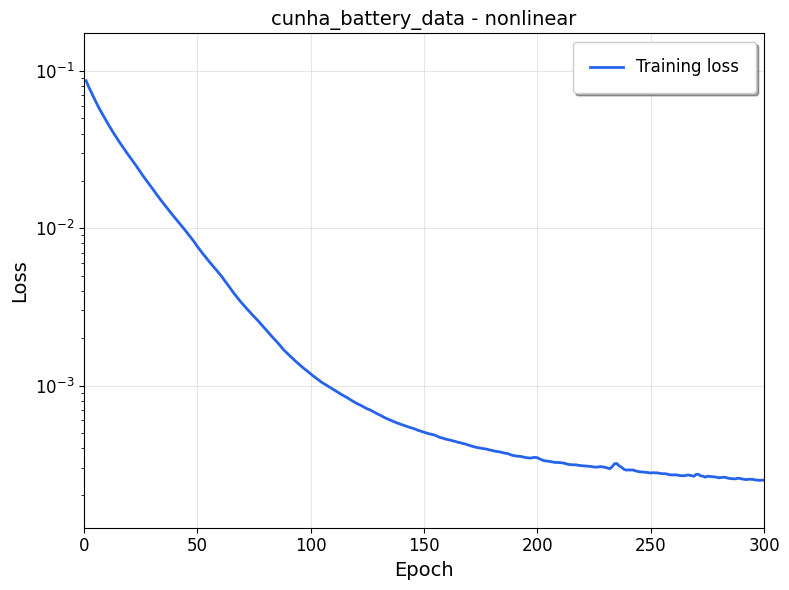

In [10]:
config["PLOT"] = {"bool_plot": True}
plot.plot_regression(regressor, data, config)

### Effect of INN Activation Functions

Available activation functions:
- polynomial
- sinusoidal
- exponential
- sigmoid
- tanh
- gelu

In [11]:
import numpy as np

INNactivations = ['polynomial', 'sinusoidal', 'exponential', 'sigmoid', 'tanh', 'gelu']
random_cases = 1  # increase for statistical significance

errors_test = np.zeros((random_cases, len(INNactivations)))
for j, INNactivation in enumerate(INNactivations):
    for i in range(random_cases):
        print(f"Running case {i+1} with activation: {INNactivation}")
        config["MODEL_PARAM"]["INNactivation"] = INNactivation
        
        regressor = train.Regression_INN(data, config)
        regressor.train()
        errors_test[i, j] = regressor.error_test
        print(f"Test Error: {regressor.error_test:.4e}")

Running case 1 with activation: polynomial
edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840
Epoch 30: Train rmse=1.7584e-01, Val rmse=2.0710e-01
Epoch 60: Train rmse=1.0071e-01, Val rmse=1.2061e-01
Epoch 90: Train rmse=5.9808e-02, Val rmse=6.9841e-02
Epoch 120: Train rmse=3.8713e-02, Val rmse=4.3825e-02
Epoch 150: Train rmse=2.8206e-02, Val rmse=3.1231e-02
Epoch 180: Train rmse=2.3116e-02, Val rmse=2.5206e-02
Epoch 210: Train rmse=2.0300e-02, Val rmse=2.1687e-02
Epoch 240: Train rmse=1.8601e-02, Val rmse=2.0038e-02
Epoch 270: Train rmse=1.7550e-02, Val rmse=1.9266e-02
Epoch 300: Train rmse=1.6839e-02, Val rmse=1.8683e-02
Training completed in 0.89 seconds
Test rmse: 1.7139e-02
Inference time: 0.000000 seconds
Test Error: 1.7139e-02
Running case 1 with activation: sinusoidal
edex_max / ndex_max: 6 / 5
------------ INN CP nonlinear, nmode: 10, nseg: 20, s=2, P=2 -------------
# of training parameters: 840


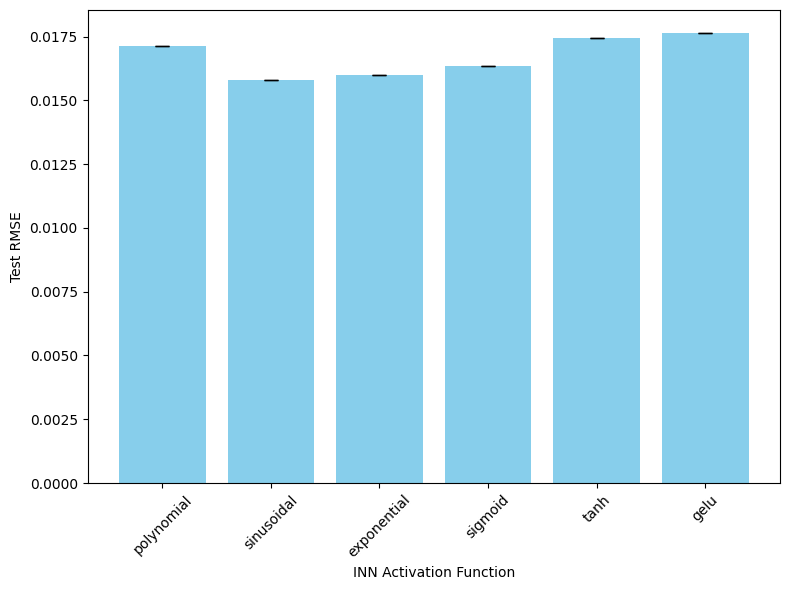

In [12]:
import matplotlib.pyplot as plt

errors_test_mean = np.mean(errors_test, axis=0)
errors_test_std = np.std(errors_test, axis=0)

plt.figure(figsize=(8, 6))
plt.bar(INNactivations, errors_test_mean, yerr=errors_test_std, capsize=5, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Test RMSE')
plt.xlabel('INN Activation Function')
plt.tight_layout()
plt.show()

### Comparison with MLP

In [13]:
config["MODEL_PARAM"] = {
    "nlayers": 3,
    "nneurons": 20,
    "activation": "sigmoid"
}
config['interp_method'] = "MLP"

------------ MLP, [4, 20, 20, 20, 1] -------------
# of training parameters: 961
Epoch 30: Train rmse=2.5797e-01, Val rmse=2.7822e-01
Epoch 60: Train rmse=2.5076e-01, Val rmse=2.7072e-01
Epoch 90: Train rmse=2.4028e-01, Val rmse=2.5851e-01
Epoch 120: Train rmse=2.2512e-01, Val rmse=2.4279e-01
Epoch 150: Train rmse=2.0299e-01, Val rmse=2.1752e-01
Epoch 180: Train rmse=1.7288e-01, Val rmse=1.8497e-01
Epoch 210: Train rmse=1.3759e-01, Val rmse=1.4303e-01
Epoch 240: Train rmse=1.0423e-01, Val rmse=1.0558e-01
Epoch 270: Train rmse=8.2066e-02, Val rmse=8.1189e-02
Epoch 300: Train rmse=6.9393e-02, Val rmse=6.7664e-02
Training completed in 0.68 seconds
Test rmse: 7.3030e-02
Inference time: 0.000000 seconds
Loss plot saved to: plots\cunha_battery_data_MLP_loss_300epoch.png


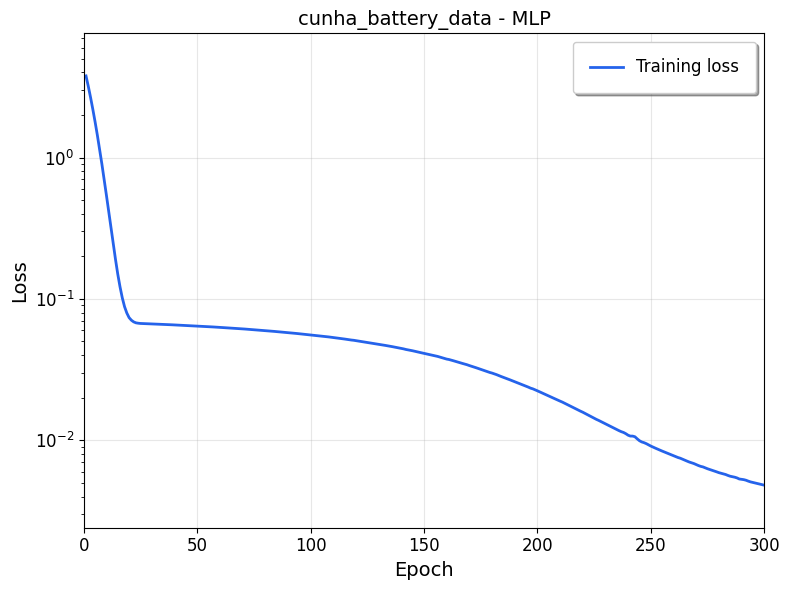

In [14]:
regressor_mlp = train.Regression_MLP(data, config)
regressor_mlp.train()

config["PLOT"] = {"bool_plot": True}
plot.plot_regression(regressor_mlp, data, config)

### Comparison with PGD (INN with Q=1 linear interpolation)

In [15]:
config["MODEL_PARAM"] = {
    "nmode": 10,
    "nseg": 20,
    "s_patch": 0  # Q=1 linear -> PGD
}
config['interp_method'] = "linear"
config['TD_type'] = "CP"

------------ INN CP linear, nmode: 10, nseg: 20 -------------
# of training parameters: 840
Epoch 30: Train rmse=1.4289e-01, Val rmse=1.3989e-01
Epoch 60: Train rmse=7.5404e-02, Val rmse=7.5810e-02
Epoch 90: Train rmse=4.6941e-02, Val rmse=4.5022e-02
Epoch 120: Train rmse=3.4204e-02, Val rmse=3.1411e-02
Epoch 150: Train rmse=2.7880e-02, Val rmse=2.5490e-02
Epoch 180: Train rmse=2.3959e-02, Val rmse=2.1648e-02
Epoch 210: Train rmse=2.1333e-02, Val rmse=1.9294e-02
Epoch 240: Train rmse=1.9543e-02, Val rmse=1.7492e-02
Epoch 270: Train rmse=1.8202e-02, Val rmse=1.7065e-02
Epoch 300: Train rmse=1.7202e-02, Val rmse=1.6806e-02
Training completed in 0.72 seconds
Test rmse: 1.7912e-02
Inference time: 0.000000 seconds
Loss plot saved to: plots\cunha_battery_data_linear_loss_300epoch.png


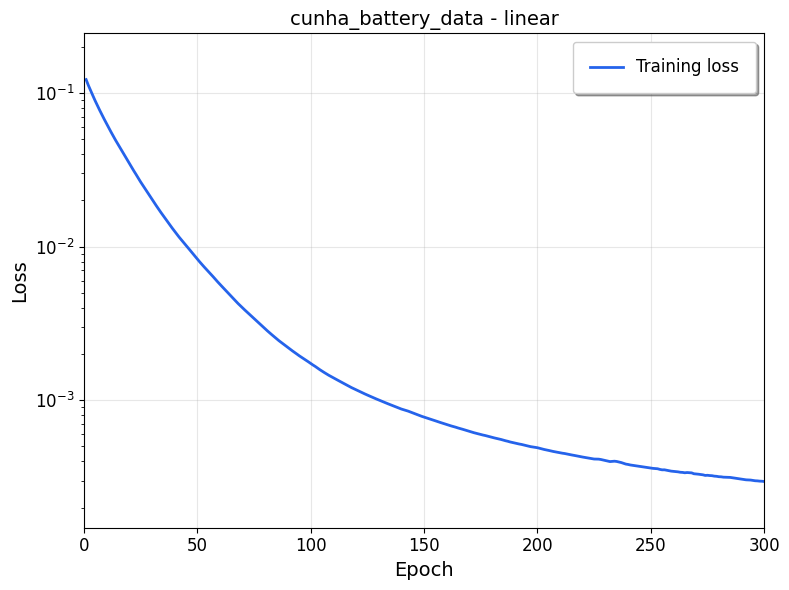

In [16]:
regressor_pgd = train.Regression_INN(data, config)
regressor_pgd.train()

config["PLOT"] = {"bool_plot": True}
plot.plot_regression(regressor_pgd, data, config)